# Integrantes do grupo:
# Andreza Lukosiunas - @andrezasp (nusp: 7157922)
# Juliano Garcia - @robotenique (nusp: 9277086)
# Pedro Carvalho - @pHrfo (nusp: 11376164)

In [1]:
# Pacotes utilizados

# Conectar-se ao Drive
from google.colab import drive

# https://docs.python.org/3/library/os.html
import os

# https://matplotlib.org/
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path as mpath

# https://pandas.pydata.org/
import pandas as pd

# https://numpy.org/
import numpy as np

# https://docs.python.org/3/library/itertools.html
import itertools

# https://pypi.org/project/Pillow/
from PIL import Image

# skimage para carregar as imagens
# https://scikit-image.org/
import skimage
from skimage import data
from skimage.morphology import disk, ball, watershed
from skimage.filters.rank import gradient
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.filters import median, gaussian
from skimage.filters import sobel, roberts, scharr
from skimage import segmentation

# https://scikit-image.org/docs/dev/api/skimage.io.html
from skimage import io

# https://pypi.org/project/opencv-python/
import cv2

# https://pypi.org/project/tqdm/
# from tqdm import tqdm
from tqdm.notebook import tqdm

# https://docs.python.org/3/library/shutil.html
import shutil

# https://docs.python.org/3/library/pathlib.html
from pathlib import Path

# https://docs.python.org/3/library/glob.html
import glob

# https://docs.python.org/3/library/collections.html
from collections import Counter

# https://docs.python.org/3/library/math.html
import math

# https://docs.python.org/3/library/json.html
import json

# https://joblib.readthedocs.io/en/latest/
import joblib

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/My Drive/MAC5768 - Visão computacional/')

# EP3 - Parte 1 - Segmentação manual e automática

In [4]:
# Lê o csv gerado pelo label studio através de polígonos
groundtruth = pd.read_csv("groundTruth/groundtruth_full.csv")

In [5]:
groundtruth.head()

,image,id,label,annotator,annotation_id
0,20210506_195343_gray2.jpg,61,"[{""points"": [[85.19515477792734, 46.0431654676...",phgcarv@gmail.com,69
1,20210509_103507_gray2.jpg,18,"[{""points"": [[47.6277476971348, 56.74837837387...",phgcarv@gmail.com,26
2,20210502_213052_gray2.jpg,90,"[{""points"": [[25.85899362592285, 72.6124958145...",phgcarv@gmail.com,98
3,20210502_213045_gray2.jpg,89,"[{""points"": [[25.841184387617766, 75.899280575...",phgcarv@gmail.com,97
4,20210502_213036_gray2.jpg,88,"[{""points"": [[14.266487213997308, 85.971223021...",phgcarv@gmail.com,96


In [6]:
# Seleciona uma imagem para verificar as técnicas de threshold
img_name = Path(groundtruth.image[0]).stem
image = mpimg.imread(f"originalGrayDataset/{img_name}.jpg")

In [7]:
image.shape

(862, 1152)

In [8]:
# A técnica do threshold otsu escolhe o melhor corte entre preto e branco para cada imagem
def thresholding_binarization(image, preprocessing_fn=None, print_=False):
  """Aplica binarização em imagens em greyscale """
  nrows, ncols = image.shape
  bin_img = np.ones([nrows + 1, ncols + 1], dtype=bool)
  image = preprocessing_fn(image) if preprocessing_fn is not None else image

  thresh = threshold_otsu(image)
  if print_: print(thresh)
  for row in range(nrows):
    for col in range(ncols):
      if image[row, col] >= thresh:
        bin_img[row, col] = False
  return bin_img

85


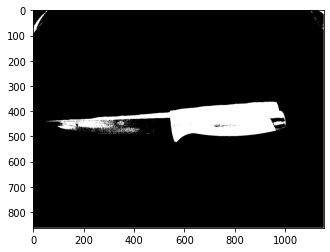

In [9]:
# Print da imagem pós threshold otsu
otsu_segmentation = thresholding_binarization(image, None, True)

plt.imshow(otsu_segmentation, cmap=plt.cm.gray)
plt.show()

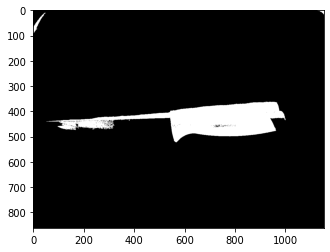

In [10]:
# Aplicamos aqui uma combinação do filtro de Sobel com o algoritmo Watershed 
# para fazer segmentação. Segue referência
# https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_coins_segmentation.html
def sobel_watershed(image):
  elevation_map = 100*sobel(image)
  markers = np.zeros_like(image)
  thresh = threshold_otsu(image)
  
  markers[image < 30] = 1
  markers[image > thresh] = 2
  
  return 1-np.array(watershed(image, markers) - 1, dtype=bool)

# Print da imagem com o filtro de sobel watershed
plt.imshow(sobel_watershed(image), cmap=plt.cm.gray)
plt.show()

## Avaliando Técnica de segmentação

In [11]:
# Reescala os pontos do polígono gerado pelo label studio confome dimensão das imagens
def rescale_points(points,image_shape):
  npoints = []
  for x,y in points:
    npoints += [(x*image_shape[1]/100, y*image_shape[0]/100)]
  return np.array(npoints)

# Define como objeto todos os pontos que estão dentro da máscara marcada pelo polígono no label studio
def make_target(image, points):
  npoints = rescale_points(points, image.shape)
  x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0])) # make a canvas with coordinates
  x, y = x.flatten(), y.flatten()
  points_mask = np.vstack((x,y)).T 

  p = mpath(npoints) # make a polygon
  grid = p.contains_points(points_mask)
  mask = grid.reshape(image.shape[0], image.shape[1])

  return mask

# Computa acurácia da segmentação em relação às imagens segmentadas manualmente (15% das imagens)
def compute_accuracy(target, segmentation):
  right = 0

  for real, pred in zip(target.flatten(), segmentation.flatten()):
    if real == pred:
      right += 1

  return right/len(target.flatten())

In [12]:
# Loop entre as imagens que passaram por ground truth manual (15% do total)
# Marca onde é objeto com a função make_target
# Aplica as duas técnicas de segmentação implementadas acima para definir qual
# tem o melhor resultado por meio da métrica obtida.
rows = [row for _, row in groundtruth.iterrows()]
otsu_accuracies = []
sw_accuracies = []

for row in tqdm(rows):
  img_name = Path(row["image"]).stem
  points = json.loads(row["label"])[0]["points"]
  image = mpimg.imread(f"originalGrayDataset/{img_name}.jpg")

  target = make_target(image, points)

  sobel_watershed_segmentation = sobel_watershed(image)
  sw_accuracies += [compute_accuracy(target, sobel_watershed_segmentation)]

  otsu_segmentation = thresholding_binarization(image)
  otsu_accuracies += [compute_accuracy(target, otsu_segmentation)]

In [13]:
df_eval = pd.DataFrame()
df_eval["otsu"] = otsu_accuracies
df_eval["sobel_watershed"] = sw_accuracies

## Report - Cálculo das métricas

In [14]:
# Report 
# Os resultados mostram que o sobel_watershed seria a melhor escolha, já que seu acurácia média é maior do que 80%
df_eval.describe()

,otsu,sobel_watershed
count,301.000000,301.000000
mean,0.621920,0.803223
std,0.207448,0.279687
min,0.051107,0.001613
25%,0.547655,0.706360
50%,0.622073,0.960137
75%,0.756666,0.986396
max,0.974802,0.998304


## Concatena os metadados dos eps anteriores, não faz parte do cálculo para nota do ep3

In [15]:
# Concatenação de todos os metadados
metadados_files = [
    "metadados/metadados_augmentedDataset.csv",
    "metadados/metadados_normalizedDataset.csv",
    "metadados/metadados_originalGrayDataset.csv",
]

metadados_new_data = pd.concat([pd.read_csv(file) for file in metadados_files], ignore_index=True).drop("Unnamed: 0", axis=1)
metadados_new_data

,arquivo,convertida,normalizada
0,20210417_153013.jpg,20210417_153013_gray.jpg,NaN
1,20210417_153013.jpg,20210417_153013_grad.jpg,NaN
2,20210417_153013.jpg,20210417_153013_excgrad.jpg,NaN
3,20210417_153013.jpg,20210417_153013_log.jpg,NaN
4,20210417_153013.jpg,20210417_153013_exp.jpg,NaN
...,...,...,...
20587,20210509_104305.jpg,20210509_104305_gray2.jpg,NaN
20588,20210509_104308.jpg,20210509_104308_gray2.jpg,NaN
20589,20210509_104313.jpg,20210509_104313_gray2.jpg,NaN
20590,20210509_104317.jpg,20210509_104317_gray2.jpg,NaN


In [16]:
metadados_original = pd.read_csv("metadados/metadados.csv").drop("Unnamed: 0", axis=1)

In [17]:
metadados_original

,arquivo,classe,objecto,repeticao,fundo,iluminacao,local,resolucao,tamanho
0,20210417_153013.jpg,óculos,óculos gucci,1,branco_2,dia,interno,2560x1440,1144814.0
1,20210417_153014(0).jpg,óculos,óculos gucci,2,branco_2,dia,interno,2560x1440,1128321.0
2,20210417_153014.jpg,óculos,óculos gucci,3,branco_2,dia,interno,2560x1440,1118719.0
3,20210417_153025(0).jpg,óculos,óculos dior,1,branco_2,dia,interno,2560x1440,1084526.0
4,20210417_153025.jpg,óculos,óculos dior,2,branco_2,dia,interno,2560x1440,1135350.0
...,...,...,...,...,...,...,...,...,...
1579,20210509_104305.jpg,charger,samsung,3,pink,dia,externo,5760x4312,7520599.0
1580,20210509_104308.jpg,charger,iphone,3,pink,dia,externo,5760x4312,7635885.0
1581,20210509_104313.jpg,charger,tablet,3,pink,dia,externo,5760x4312,7477171.0
1582,20210509_104317.jpg,charger,double,3,pink,dia,externo,5760x4312,7102664.0


In [18]:
metadados_full = metadados_new_data.join(metadados_original.set_index("arquivo"), on="arquivo").drop_duplicates(subset=["convertida"])

In [19]:
metadados_full.head()

,arquivo,convertida,normalizada,classe,objecto,repeticao,fundo,iluminacao,local,resolucao,tamanho
0,20210417_153013.jpg,20210417_153013_gray.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
1,20210417_153013.jpg,20210417_153013_grad.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
2,20210417_153013.jpg,20210417_153013_excgrad.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
3,20210417_153013.jpg,20210417_153013_log.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
4,20210417_153013.jpg,20210417_153013_exp.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0


In [20]:
metadados_full.convertida.value_counts()

PHOTO_20210502_145656_excgrad.jpg    1
PHOTO_20210502_145643_mean.jpg       1
20210501_152719_mean.jpg             1
20210417_161349_excgrad.jpg          1
20210417_191716(0)_exp.jpg           1
                                    ..
20210417_154444(0)_gray.jpg          1
PHOTO_20210502_151510_grad.jpg       1
20210417_184004_grad.jpg             1
PHOTO_20210502_210128_grad.jpg       1
20210509_102852_gray2.jpg            1
Name: convertida, Length: 11088, dtype: int64

In [21]:
# Salva Metadados full
metadados_full.to_csv("metadados/metadados_full.csv")

## Fim da concatenação dos metadados

## Aplicando Segmentação para todas as imagens

In [22]:
# Utiliza sobel_watershed para segmentar todas as imagens. Conforme visto acima, essa técnica atingiu melhor acurácia 
for file in tqdm(metadados_full.convertida):
  if Path(f"augmentedDataset/{file}").exists():
    image = mpimg.imread(f"augmentedDataset/{file}")
  elif Path(f"originalGrayDataset/{file}").exists():
    image = mpimg.imread(f"originalGrayDataset/{file}")
  else:
    image = mpimg.imread(f"normalizedDataset/{file}")
  
  segmented = sobel_watershed(image)
  segmented = cv2.resize(segmented.astype("float32"), dsize=(84, 56))
  joblib.dump(segmented, f"segmented/{file}.joblib")